概要：上节了解梯度下降等算法，批量梯度算法如果数据集很大，非常耗时，需要很大的内存空间；随机梯度算法在计算每个梯度时，随机选择一个样本来计算，节约了计算成本，小批量梯度算法也类似；本节介绍数据集的正则化。

1.设置绘图环境。

In [42]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2.线性回归方程的参数。

$ \hat{\theta} = (X^T \cdot X)^{-1} \cdot X^T \cdot y$

$ \hat\theta $是参数矩阵，该参数可以根据上述方程直接求解。

生成随机数据，测试线性模型：

In [43]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [44]:
X.shape

(100, 1)

显示这些随机数据：

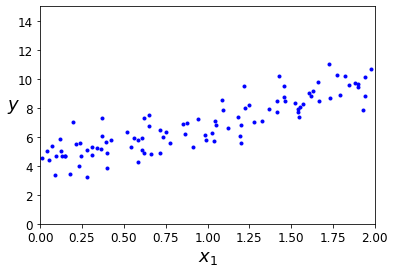

In [45]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

我们用inv，dot来计算：

In [46]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [47]:
theta_best

array([[4.21509616],
       [2.77011339]])

得到的参数值是3.93829632和3.1429825，原始的值是4和3，但由于存在噪声数据，只可能达到
近似值。

预测一下新的值：

In [48]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

将数据集和预测的点画出来：

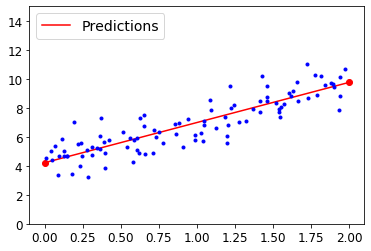

In [49]:
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X_new, y_predict, "ro")
plt.plot(X, y, "b.")
plt.axis([-0.1, 2.1, 0, 15])
plt.legend(loc="upper left", fontsize=14)
plt.show()

图中的红点，就是预测的点的坐标。

用scikit代码可以实现同样的效果：

In [50]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [51]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

和我们用方程得到的结果是一样的。

3.线性回归模型的损失函数。

我们使用均方差MSE来计算损失函数：

$$ MSE(X, h_\theta) = \frac{1}{m} \sum_{i=0}^m {(\theta^T \cdot x^{(i)} - y^{(i)} )^2} $$

4.梯度下降算法。

如果直接用方程求解，那么当训练集很大时计算量也是非常大的；我们用梯度下降算法来做优化。

算法思路：开始时，需要选定一个随机的$ \theta $（这个值称为随机初始值），然后逐渐去改进它，
每一次变化一小步，每一步都试着降低损失函数（例如：均方差损失函数），直到算法收敛
到一个最小值。

* 在梯度下降中一个重要的参数是步长，超参数学习率的值决定了步长的大小。如果学习率太
小，必须经过多次迭代，算法才能收敛，这是非常耗时的。

* 另一方面，如果学习率太大，你将跳过最低点，到达山谷的另一面，可能下一次的值比上一
次还要大。这可能使的算法是发散的，函数值变得越来越大，永远不可能找到一个好的答案。

特征需要正则化：当我们使用梯度下降的时候，应该确保所有的特征有着相近的尺度范围（例如：使用
Scikit Learn 的 StandardScaler 类），否则它将需要很长的时间才能够收敛。

5.批量梯度下降算法。

在使用梯度算法中，你要计算当 $ \theta _j$改变时，损失函数的变化量，如果特征参数非常多时，非常耗时；这叫计算$ \theta _j$的损失函数的偏导数，公式如下：

$$ \frac{\partial}{\partial \theta _j} MSE(\theta) = \frac{2}{m} \sum _{i=1} ^{m} { (\theta ^T \cdot x^{(i)} - y^{(i)} ) x_j^{(i)}  } $$

为了避免计算每个特征的梯度，可以使用下面的公式一起计算它们，包含了损失函数所有的偏导数：

$$ \nabla_\theta MSE(\theta) = \left( \frac{\partial}{\partial \theta _0} MSE(\theta) , \cdots , \frac{\partial}{\partial \theta _n} MSE(\theta) \right) = \frac{2}{m} X^T \cdot (X \cdot \theta - y) $$

$ \theta $的步长等于学习率和梯度向量的点积：

$$ \theta^{(next step)} = \theta - \eta \cdot \nabla_\theta MSE(\theta) $$

In [52]:
np.random.randn(2,1)

array([[0.01300189],
       [1.45353408]])

6.梯度下降算法的应用。

In [53]:
eta = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [54]:
theta

array([[4.21509616],
       [2.77011339]])

计算出来的值和解正规方程是一样的。

In [55]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

我们把不同学习率情况下梯度下降算法的效果打印出来：

In [56]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

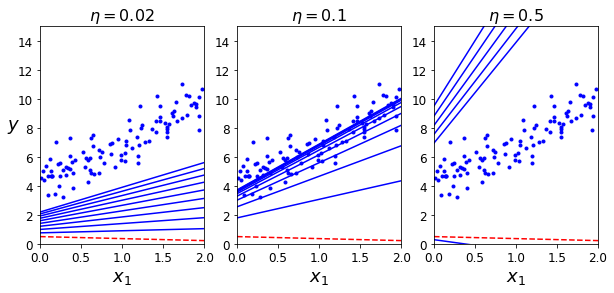

In [57]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

当学习率为0.02时，算法收敛的很慢；0.1时运算遍历了10次就达到了比较好的效果；0.5时算法直接发散了，离正确的结果越来越远。

7.随机梯度下降算法。

批量梯度算法的问题是每计算一步梯度都要遍历整个数据集，这样在数据集非常大的时候速度会很慢；而随机梯度下降算法在计算每个梯度时，只是从数据集中随机选择一个样本来计算，这样速度得到了提高。

下面我们看代码;

In [58]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

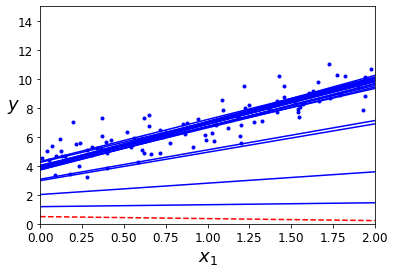

In [59]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
plt.show()                                           # not shown

以上显示的是迭代前20次的参数收敛情况。

In [60]:
theta

array([[4.21076011],
       [2.74856079]])

接近正规方程的解。

下面使用scikit的随机梯度下降算法：

In [61]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=50,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
             warm_start=False)

学习率使用0.1，损失函数用squared_loss均方差函数。

In [62]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.16782089]), array([2.72603052]))

得到的结果也接近正规方程的解。

8.小批量梯度下降算法。

在计算梯度时，只使用数据集中的一小部分，优点是可以在GPU硬件加速中有较好的性能表现。

In [63]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [64]:
theta

array([[4.25214635],
       [2.7896408 ]])

下面我们比较一下三种梯度下降算法参数的收敛情况：

In [65]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

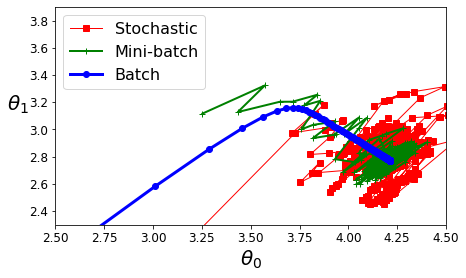

In [66]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

批量梯度算法最后收敛在了最小值，而随机梯度和小批量梯度在最小值附件摆动；但批量梯度要花费更多的时间；同时如果使用了较好的学习率优化函数，他们也可以达到最小值。

9.多项式回归。

如果数据比简单的直线更复杂，一个简单的方法是对每个特征进行加权后作为新的特征，然后训练一个线性
模型在这个扩展的特征集。 这种方法称为多项式回归，例如：

In [69]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [89]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

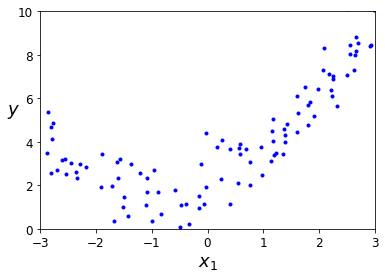

In [90]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

这些点用直线已经无法拟合了，我们用PolynomialFeatures把多项式加权，获得新的特征：

In [91]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([0.39842784])

In [92]:
X_poly[0]

array([0.39842784, 0.15874475])

X_poly经过加权后，不仅包括原来的特征$ X $，还包括新的特征$ X^2 $：

In [93]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.07805933]), array([[0.9457446 , 0.55066663]]))

得到的系数是0.93366893和0.56456263，实际是1和0.5，已经非常接近了。

我们画出拟合曲线：

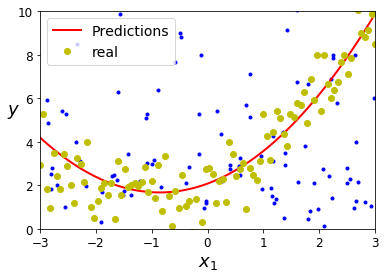

In [94]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
y = 0.5 * X_new**2 + X_new + 2 + np.random.randn(m, 1)

X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.plot(X_new, y, "yo", linewidth=2, label="real")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

蓝点是训练数据，红色曲线是测试数据曲线，黄色的点是真实的测试值，拟合的不错。

使用高阶多项式会拟合的比较好，下面比较300阶，2阶和简单线性回归的拟合效果：

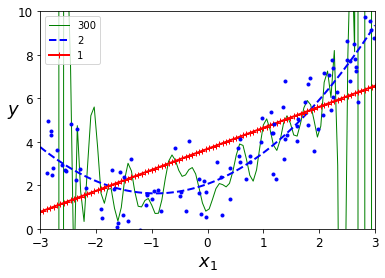

In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

简单的线性回归没有很好的拟合数据，二项式就很好的拟合了数据，因为数据就是二项式产生的；300阶的多项式显然过度拟合了。

9.欠拟合和过拟合。

欠拟合：模型在训练集和验证集上的误差都很大，这是增加训练样本数量没有用，需要用更复杂的模型或者找到更有效的特征。

过拟合：模型在训练集上的误差都很小，但是在验证集上的误差很大，这说明模型出现了过拟合，可以通过增加训练样本来解决。

* 可以通过交叉验证的方法，来确定模型到底是欠拟合还是过拟合。

另一方面可以通过观察学习曲线，需要训练不同的样本数量，得到对应的误差值：

In [95]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

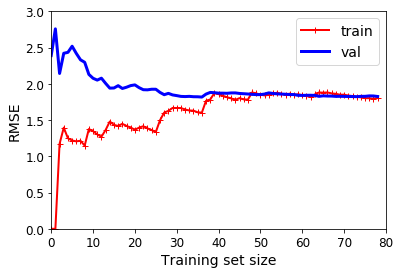

In [96]:
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
plt.show()   

In [ ]:
上面我们用线性回归来拟合二项式数据，我们看到误差率非常高，在训练集和测试集上的效果都不好，显然是模型欠拟合了。